In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from top2vec import Top2Vec

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD

import pickle
from pathlib import Path
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
path_train_split = Path('../../data/corpora/ttsplit.pickle')

In [3]:
with open(path_train_split, 'rb') as file:
    data_with_tag_index, train_index, test_index, y, label_binarizer = pickle.load(file)

print(train_index.shape)
print(test_index.shape)

(80697,)
(39747,)


In [4]:
# path_emb = Path('../../data/emb/tutby_126784_doc_rubert.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # 0.558 + 8ep

# path_model_top2vec = Path('../../data/model/t2v/top2vec_126784.joblibfile')
# model = Top2Vec.load(path_model_top2vec)
# x = model.model.docvecs.vectors_docs  # 0.548 + 4ep

# path_emb = Path('../../data/emb/clean_tutby_126784_w2v_idf.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # 0.542 + 8ep
#     x *= 10000

# path_emb = Path('../../data/emb/tutby_126784_doc_rubert_tokenw.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # 0.539 + 2ep
#     x *= 10000


path_emb = Path('../../data/emb/emb_tutby_126784_header_bert.npy')
with open(path_emb, 'rb') as file:
    x = np.load(file)  # 0.474 + 4ep

# path_emb = Path('../../data/emb/emb_clean_tutby_126784_header_w2v_idf.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # 0.469 + 10ep
#     x *= 10000

# path_emb = Path('../../data/emb/emb_tutby_126784_header_sbert.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # 0.466 + 8ep

# path_emb = Path('../../data/emb/emb_clean_tutby_126784_header_d2v.npy')
# with open(path_emb, 'rb') as file:
#     x = np.load(file)  # >0.376 + >20ep
#     x *= 10


x = x[data_with_tag_index]
print(x.shape)

(120444, 768)


In [5]:
x_train = x[train_index]
x_test = x[test_index]
y_train = y[train_index]
y_test = y[test_index]

assert len(x_train) + len(x_test) == len(y)

index_not_nan = ~np.isnan(x_train).any(axis=1)
x_train = x_train[index_not_nan]
y_train = y_train[index_not_nan]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80697, 768)
(80697, 138)
(39747, 768)
(39747, 138)


In [6]:
%%time
# softmax regression

model = Sequential()
# model.add(Dense(y.shape[1], activation='sigmoid', input_dim=x.shape[1]))
model.add(Dense(y.shape[1], activation='softmax', input_dim=x.shape[1]))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=32, validation_split=0.2)

pred = model.predict(x_test)

# pred = pred > 0.5

Epoch 1/4
2018/2018 [==============================] - 16s 8ms/step - loss: 0.0226 - categorical_accuracy: 0.4321 - val_loss: 0.0210 - val_categorical_accuracy: 0.4548
Epoch 2/4
2018/2018 [==============================] - 11s 6ms/step - loss: 0.0198 - categorical_accuracy: 0.4860 - val_loss: 0.0205 - val_categorical_accuracy: 0.4715
Epoch 3/4
2018/2018 [==============================] - 13s 6ms/step - loss: 0.0190 - categorical_accuracy: 0.5032 - val_loss: 0.0205 - val_categorical_accuracy: 0.4701
Epoch 4/4
2018/2018 [==============================] - 16s 8ms/step - loss: 0.0185 - categorical_accuracy: 0.5148 - val_loss: 0.0204 - val_categorical_accuracy: 0.4711
Wall time: 1min 2s


In [7]:
y_test_label = label_binarizer.inverse_transform(y_test)
pred_label = label_binarizer.inverse_transform(pred)

print(accuracy_score(y_test_label, pred_label))  

for a, b in zip(y_test_label[:10], pred_label[:10]):
    print(f'{a} --- {b}')

0.47387224193020855
природа --- наука
кндр --- дипломатия
наука --- наука
гаджеты --- гаджеты
автомобили --- автомобили
суды --- криминал
погода --- погода
история беларуси --- министерства
транспорт --- транспорт
видео tut.by --- дети


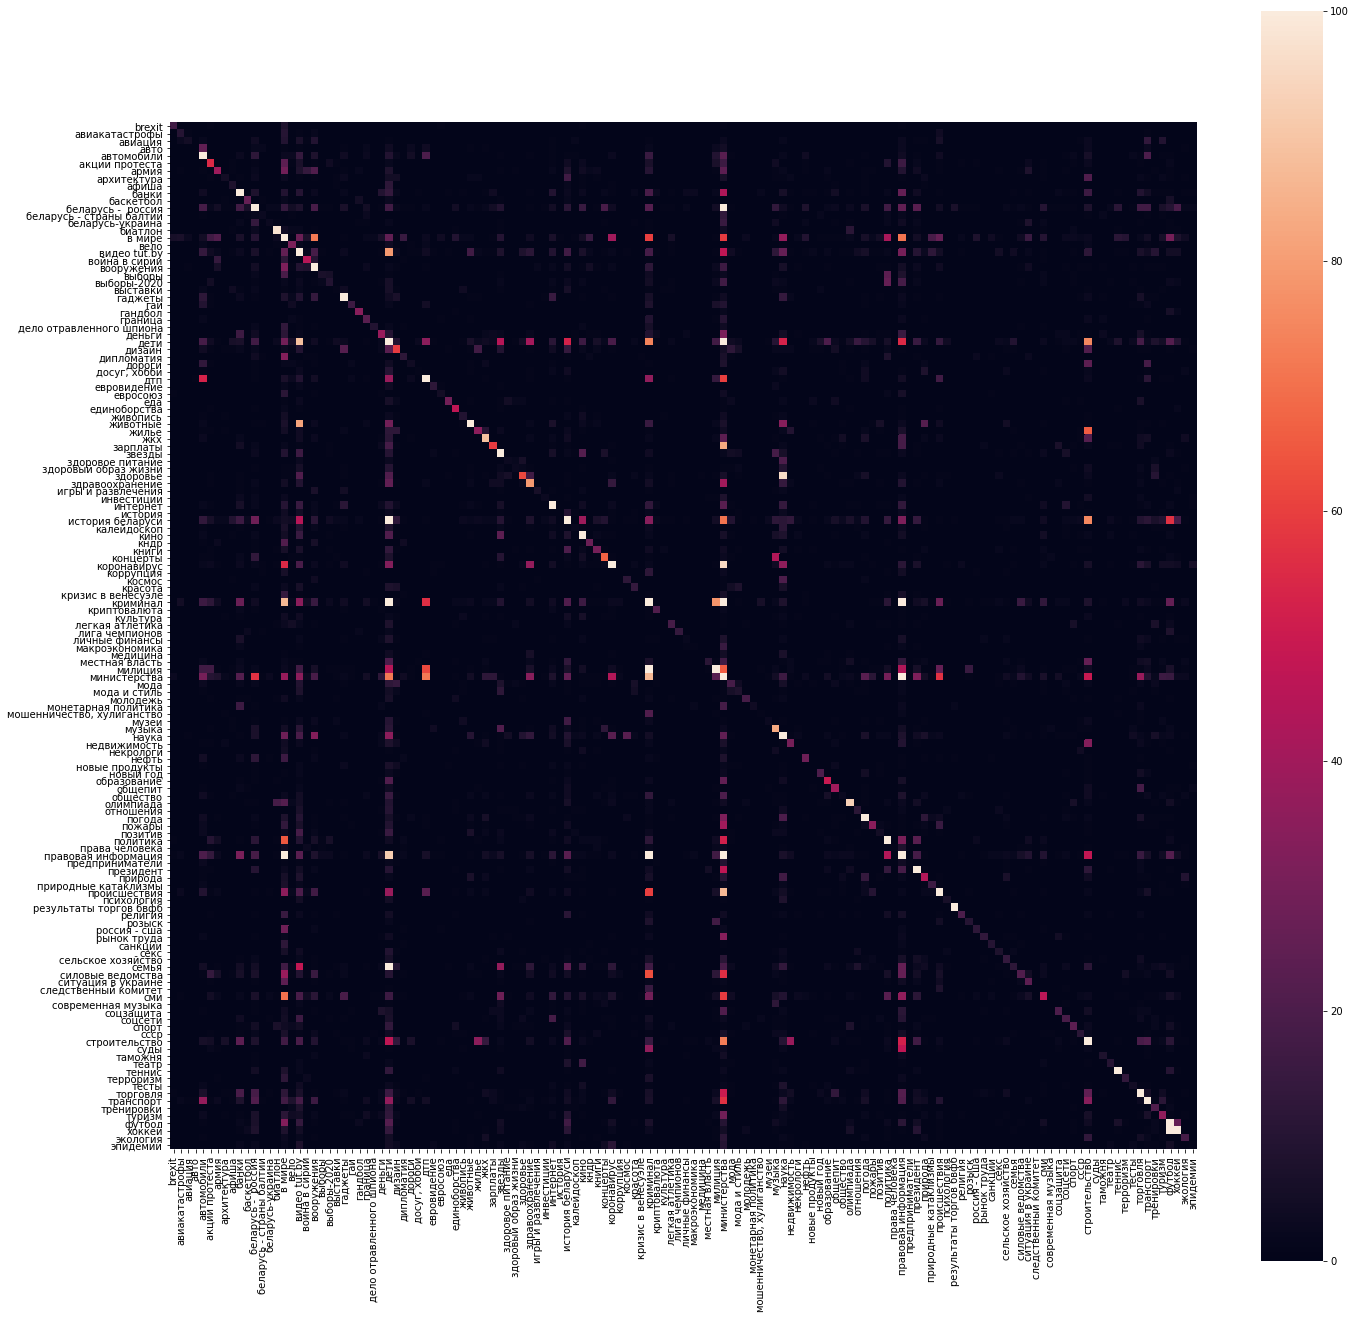

In [8]:
cm = confusion_matrix(y_test_label, pred_label, labels=label_binarizer.classes_)

plt.figure(figsize=(23, 23))
sns.heatmap(cm, vmax=100, annot=False, square=True, 
            xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_);